# DIP-Project-By RJ Revin Chrisbert, Mohamed Farook SK, Abhishek Rajan K

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Creating Dataframe and Importing Data

In [3]:
import os
import pandas as pd

train_dir = 'D:\Phone\download\DIP practicals\DIP project\DIP Project Skin Cancer\Skin cancer ISIC The International Skin Imaging Collaboration\Train'
test_dir = 'D:\Phone\download\DIP practicals\DIP project\DIP Project Skin Cancer\Skin cancer ISIC The International Skin Imaging Collaboration\Test'

# Create dataframes
# Create lists to hold the data
train_data = []
test_data = []

# Populate the training data list
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

# Create the training DataFrame from the list
train_df = pd.DataFrame(train_data)

# Populate the test data list
for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create the test DataFrame from the list
test_df = pd.DataFrame(test_data)

# Combine train and test df if needed
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the final dataframe
print(df.head())

                                          image_path  label
0  D:\Phone\download\DIP practicals\DIP project\D...      0
1  D:\Phone\download\DIP practicals\DIP project\D...      0
2  D:\Phone\download\DIP practicals\DIP project\D...      0
3  D:\Phone\download\DIP practicals\DIP project\D...      0
4  D:\Phone\download\DIP practicals\DIP project\D...      0


In [4]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'No Cancer',
 6: 'pigmented benign keratosis',
 7: 'seborrheic keratosis',
 8: 'squamous cell carcinoma',
 9: 'vascular lesion'}

In [5]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               No Cancer                      94        
6               pigmented benign keratosis     478       
7               seborrheic keratosis           80        
8               squamous cell carcinoma        197       
9               vascular lesion                142       
------------------------------------------------------------
Total                                         2451      


# Loading/resizing of images

In [6]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\REVIN CHRISBERT\AppData\Local\Temp\ipykernel_15680\3886418994.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [7]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [8]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

16

In [9]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [10]:
df.head()

,image_path,label,image
0,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,D:\Phone\download\DIP practicals\DIP project\D...,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


> # Displaying the total number of images of each Class

In [11]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               No Cancer                      94        
6               pigmented benign keratosis     478       
7               seborrheic keratosis           80        
8               squamous cell carcinoma        197       
9               vascular lesion                142       
------------------------------------------------------------
Total                                         2451      


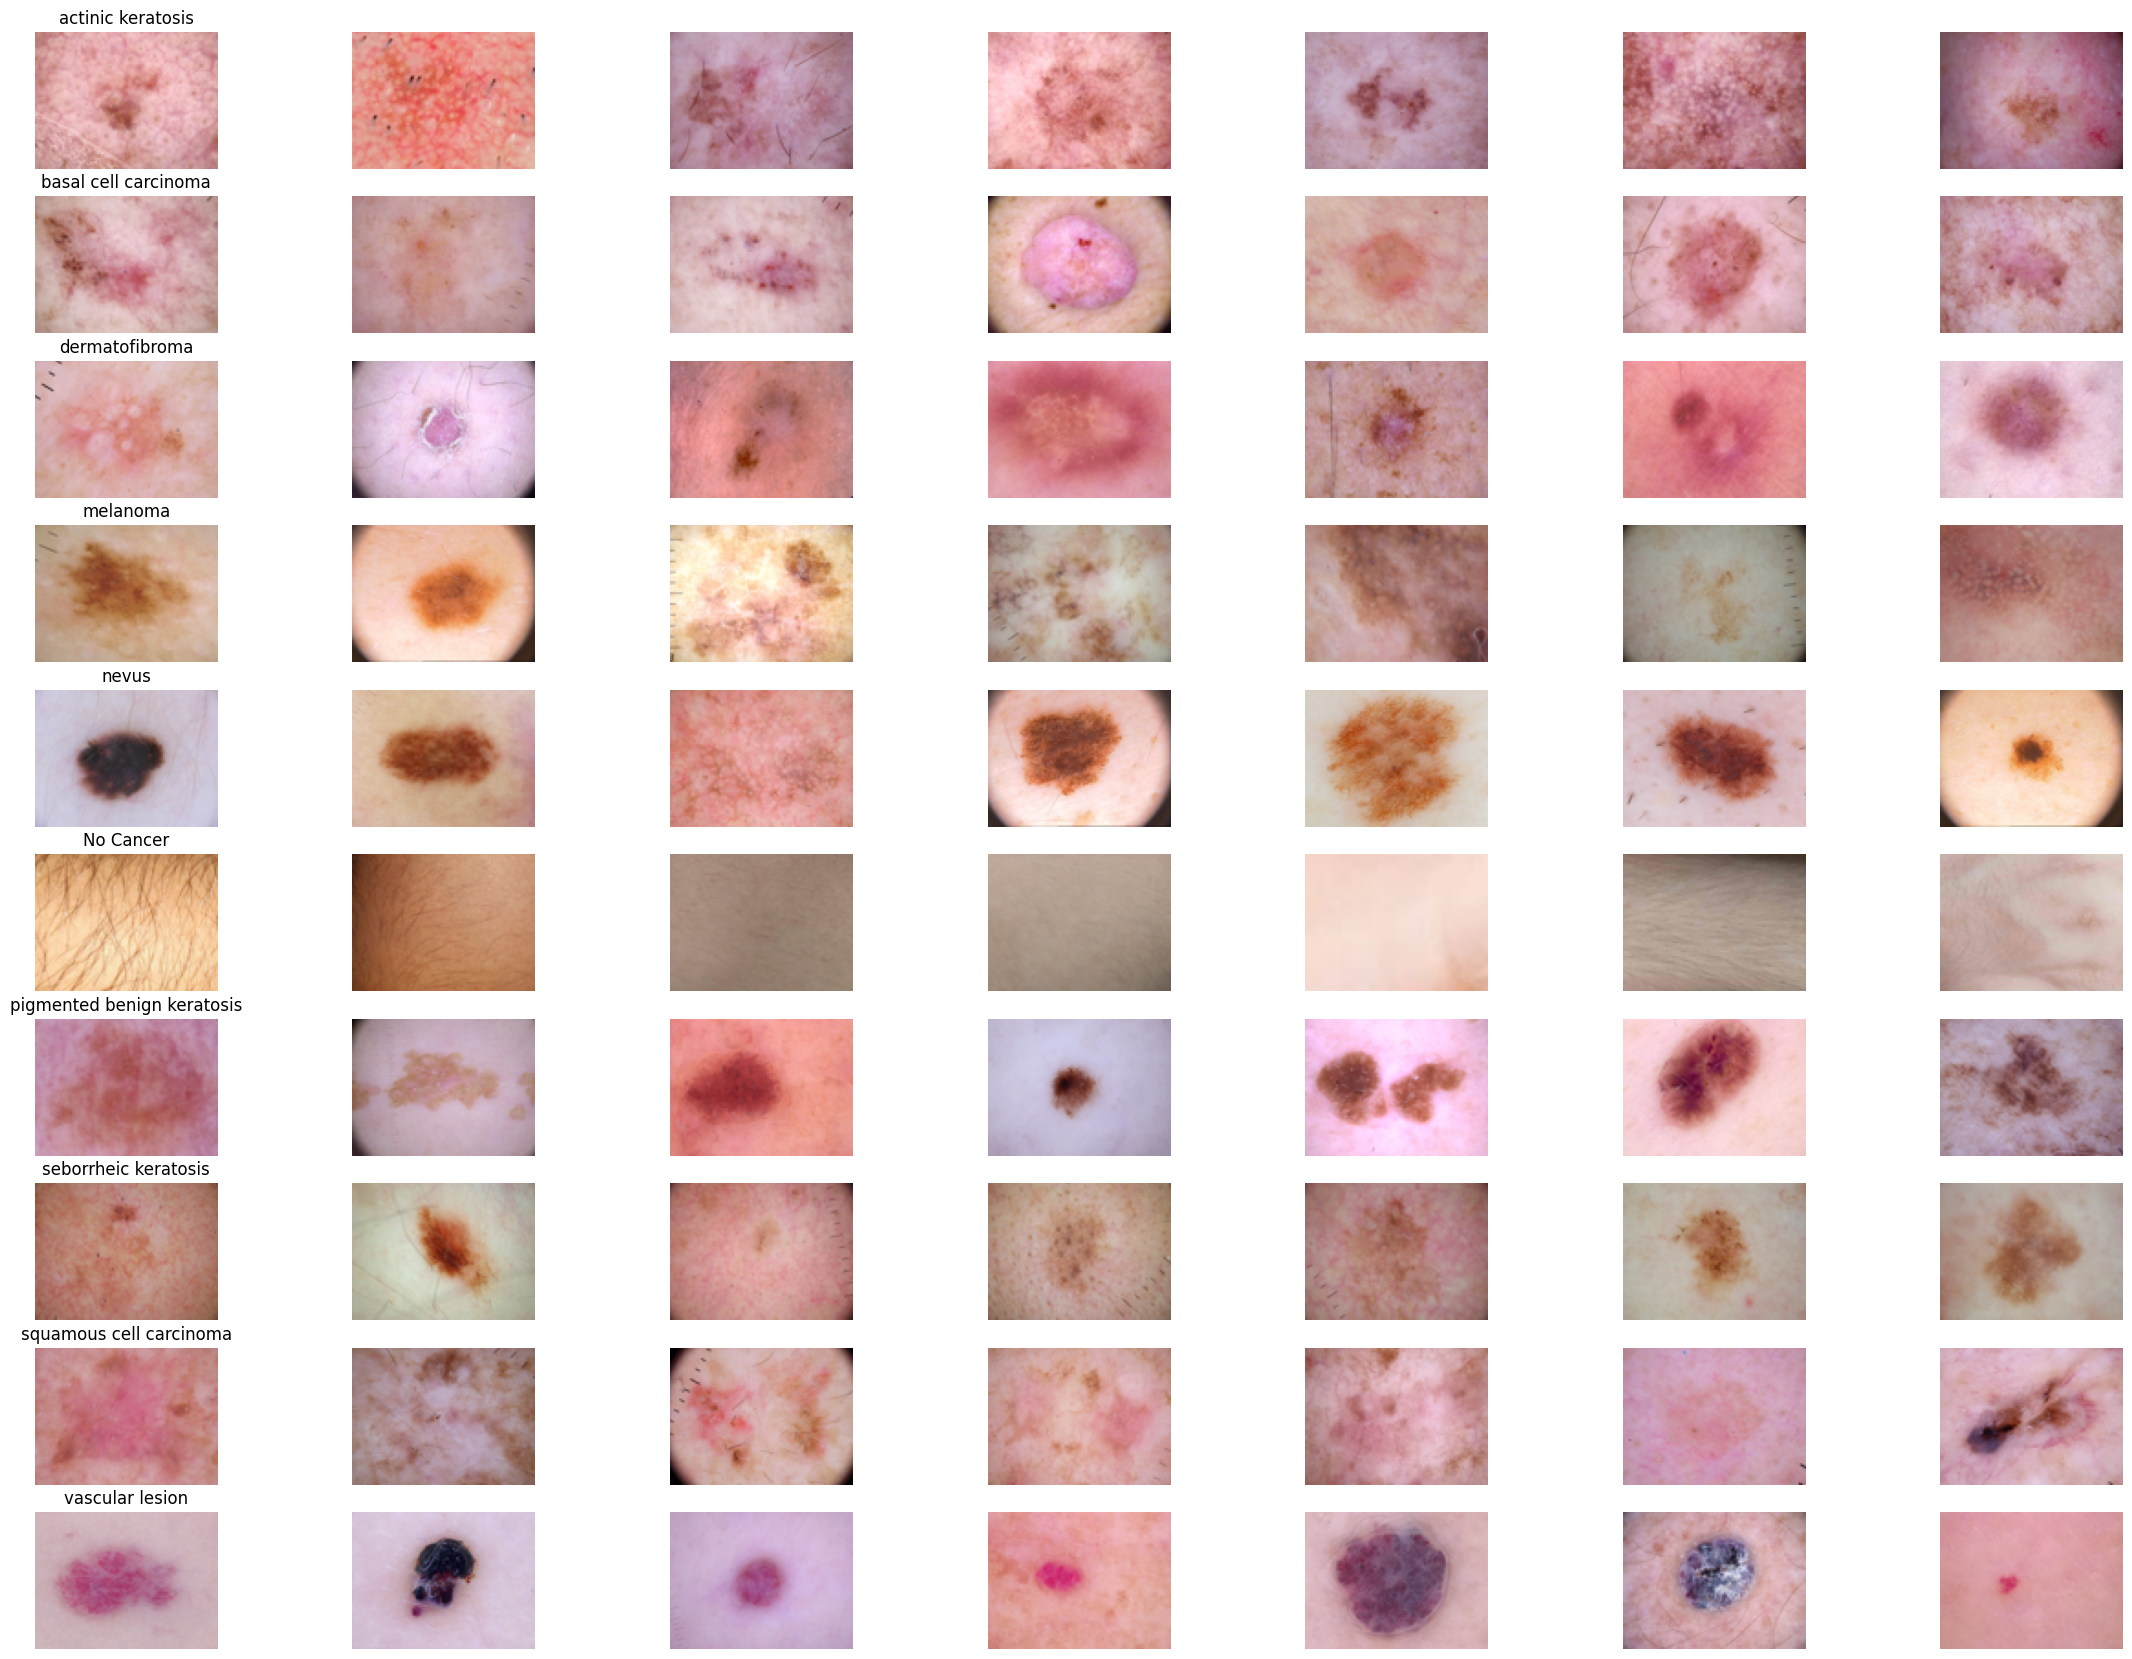

In [12]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2451
Name: count, dtype: int64

# Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [15]:
# Create an empty list to store all image data (original and augmented)
all_images_data = []
max_images_per_class = 500 # Make sure this variable is defined

# Loop through each class and balance the data by augmenting images
for class_label in df['label'].unique():
    class_df = df[df['label'] == class_label]
    
    # First, add all the original images for this class to our list
    all_images_data.extend(class_df.to_dict('records'))
    
    # Calculate how many new images we need to generate
    num_images_needed = max_images_per_class - len(class_df)
    
    if num_images_needed > 0:
        # Get the numpy arrays of the original images to use for augmentation
        image_arrays_to_augment = class_df['image'].values
        
        # Randomly select images to augment. 'replace=True' allows us to pick the same image multiple times.
        selected_image_arrays = np.random.choice(image_arrays_to_augment, size=num_images_needed, replace=True)
        
        # Generate one new image for each selection
        for image_array in selected_image_arrays:
            # Reshape the image array to (1, height, width, channels) for the generator
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Create an iterator that will generate augmented versions of this single image
            iterator = datagen.flow(image_tensor, batch_size=1)
            
            # Get the next (and only) augmented image from the iterator
            augmented_image_array = next(iterator)[0].astype('uint8')
            
            # Add the new augmented image's data to our list
            all_images_data.append({
                'image_path': None, # Augmented images don't have a file path
                'label': class_label,
                'image': augmented_image_array
            })

# Create the final, balanced DataFrame from the list in a single, efficient operation
final_df = pd.DataFrame(all_images_data)

# Shuffle the final DataFrame to mix original and augmented images, then reset the index
df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Clean up the temporary DataFrame from memory
del final_df

> # Displaying the total number of images of each Class after Data Augmentation

In [16]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              500       
1               basal cell carcinoma           500       
2               dermatofibroma                 500       
3               melanoma                       500       
4               nevus                          500       
5               No Cancer                      500       
6               pigmented benign keratosis     500       
7               seborrheic keratosis           500       
8               squamous cell carcinoma        500       
9               vascular lesion                500       
------------------------------------------------------------
Total                                         5000      


# Spliting the Dataset into Train and Test 

In [17]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [18]:
features.head()

,image
0,"[[[169, 145, 140], [170, 144, 140], [170, 145,..."
1,"[[[148, 134, 133], [150, 136, 135], [152, 138,..."
2,"[[[156, 130, 115], [156, 130, 115], [156, 130,..."
3,"[[[176, 167, 190], [184, 172, 191], [187, 176,..."
4,"[[[169, 119, 118], [172, 122, 124], [174, 124,..."


In [19]:
target.head()

0    3
1    5
2    5
3    2
4    1
Name: label, dtype: int64

In [20]:
print(target.shape,features.shape)

(5000,) (5000, 1)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [47]:
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization of Data

In [23]:
x_train = np.asarray(X_train['image'].tolist())
x_test = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

In [24]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Spliting data into training and Validation Split

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [26]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [27]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [28]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              340        76           84         500       
1               basal cell carcinoma           336        70           94         500       
2               dermatofibroma                 311        76           113        500       
3               melanoma                       318        81           101        500       
4               nevus                          320        96           84         500       
5               No Cancer                      320        72           108        500       
6               pigmented benign keratosis     324        67           109        500       
7               seborrheic keratosis           299        

In [29]:
df.groupby('label').size()

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
dtype: int64

In [30]:
input_shape = df['image'][0].shape

#  Model Architecture

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import DenseNet201

# --- 1. Load the DenseNet201 Base ---
# Get the input shape from your data (e.g., (75, 100, 3))
# Make sure your 'x_train_stacked' or 'x_train' variable is 4D first
input_shape = (75, 100, 3) # Or whatever your shape is

base_model = DenseNet201(include_top=False, 
                         weights='imagenet', 
                         input_shape=input_shape)

# --- 2. THIS IS THE CRITICAL FIX ---
# Freeze the entire base model so its weights won't be trained
base_model.trainable = False

# --- 3. Build Your New Model ---
model = Sequential([
    # Add the frozen base
    base_model,
    
    # Add your custom classifier head
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # num_classes should be 10
])

# Now the model is correctly configured
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 3, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225,866 (92.41 MB)

 Trainable params: 5,903,882 (22.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

#  Setting Optimizer

In [32]:
# Import the correct Adam optimizer
from tensorflow.keras.optimizers import Adam

# 1. Define the optimizer with the increased learning rate (as per your teacher)
# We're using 0.005, but you can change this.
my_optimizer = Adam(learning_rate=0.001) 

# 2. Compile the model
model.compile(optimizer=my_optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [33]:
# Import the callback
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
# This will stop training when 'val_loss' stops improving
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              restore_best_weights=True)

# Fitting of model

In [34]:
# Define batch size
batch_size = 32

# Fit the model
history = model.fit(x_train,
                    y_train,
                    epochs=100,  # Set a high number
                    batch_size=batch_size,
                    validation_split=0.2, # <-- NEW LINE: Automatically use 20% of x_train for validation
                    callbacks=[early_stopping]) # Keep this!

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 911ms/step - accuracy: 0.3192 - loss: 7.0516 - val_accuracy: 0.5437 - val_loss: 1.3538
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 58s 721ms/step - accuracy: 0.4919 - loss: 1.4374 - val_accuracy: 0.5844 - val_loss: 1.1881
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 704ms/step - accuracy: 0.5565 - loss: 1.2448 - val_accuracy: 0.6203 - val_loss: 1.1153
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 58s 729ms/step - accuracy: 0.6027 - loss: 1.1153 - val_accuracy: 0.6187 - val_loss: 1.0816
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 674ms/step - accuracy: 0.5723 - loss: 1.1314 - val_accuracy: 0.6203 - val_loss: 1.1436
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - accuracy: 0.6237 - loss: 1.0555 - val_accuracy: 0.6500 - val_loss: 1.0293
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 707ms/step - accuracy: 0.6123 - loss: 1.0148 - val_accuracy: 0.6500 - val_loss: 1.0236
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 709ms/step - accuracy: 0.6389 - loss: 0.9907 - 

# Model Evaluation

In [56]:
import numpy as np

try:
    # --- 1. PREPARE TEST LABELS (FORCED FLOAT32) ---
    # We now have 10 classes
    y_test_cat = to_categorical(y_test, num_classes=num_classes).astype('float32')
    
    # --- 2. PREPARE TEST IMAGES (FORCED FLOAT32) ---
    print("Preparing test images...")
    x_test_images = X_test['image'].tolist()
    x_test_stacked = np.stack(x_test_images).astype('float32') 
    
    # Cast mean and std to float32
    mean_f32 = np.float32(x_train_mean)
    std_f32 = np.float32(x_train_std)
    
    # Normalize using all float32 variables
    x_test_normalized = (x_test_stacked - mean_f32) / std_f32
    
    print("Test images are ready.")

    # --- 3. EVALUATE THE MODEL ON TEST DATA ---
    print("Evaluating model on TEST data...")
    loss, accuracy = model.evaluate(x_test_normalized, y_test_cat, verbose=1)

    print("-" * 30)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
except NameError as e:
    print(f"Error: {e}")
    print("A required variable is missing.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Preparing test images...
Test images are ready.
Evaluating model on TEST data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.7283 - loss: 0.8244
------------------------------
Test Loss: 0.8659
Test Accuracy: 72.40%


Model is making predictions on the test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 682ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.53      0.67      0.59        84
      basal cell carcinoma       0.72      0.72      0.72        94
            dermatofibroma       0.85      0.79      0.82       113
                  melanoma       0.65      0.53      0.59       101
                     nevus       0.58      0.61      0.59        84
                 No Cancer       1.00      1.00      1.00       108
pigmented benign keratosis       0.64      0.67      0.65       109
      seborrheic keratosis       0.72      0.79      0.75        99
   squamous cell carcinoma       0.57      0.49      0.53       108
           vascular lesion       0.93      0.94      0.94       100

                  accuracy                           0.72      1000
                 macro avg       0.72      0.72      0.72      1000
 

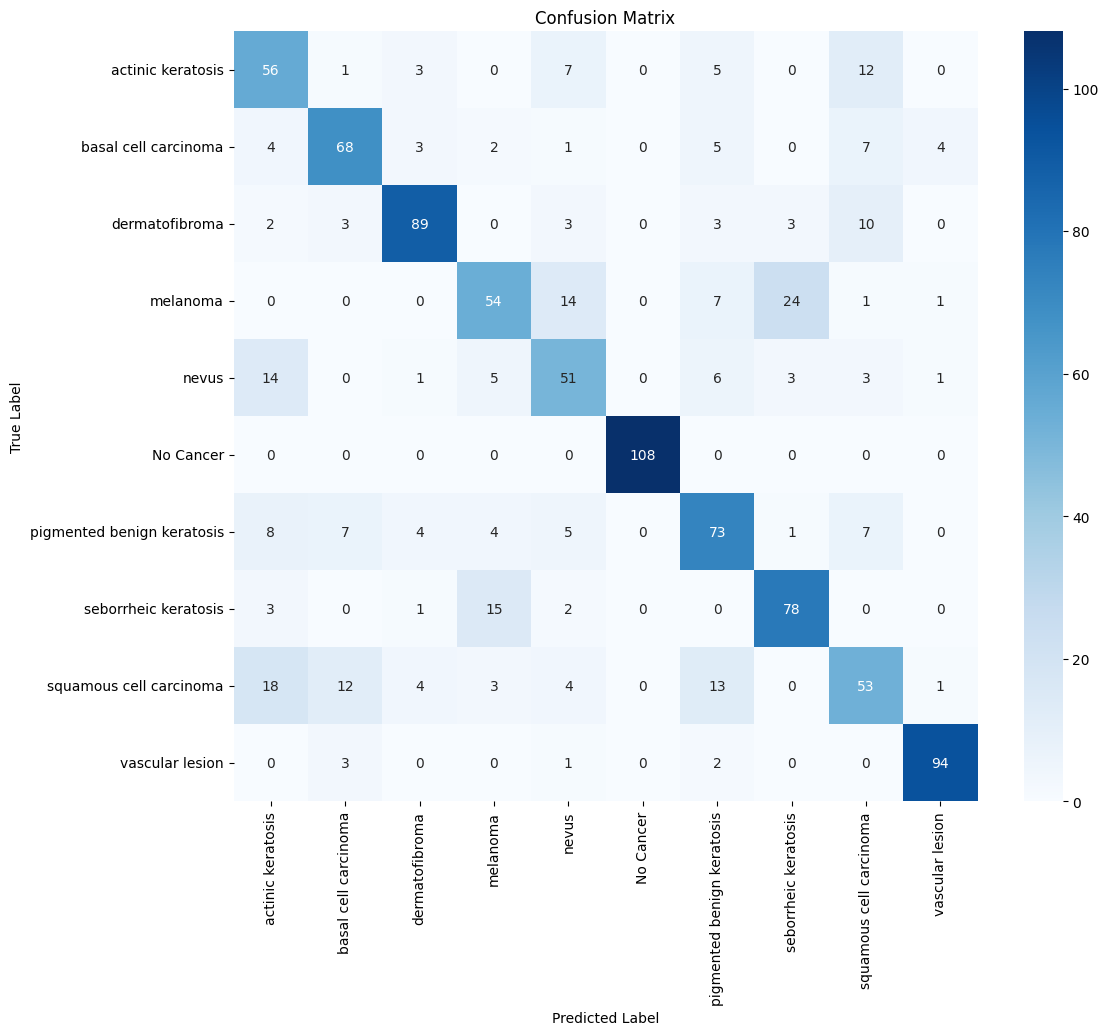

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

try:
    # --- 1. RUN PREDICTIONS ---
    # We use the 'x_test_normalized' variable we just created in the cell above
    print("Model is making predictions on the test set...")
    y_pred_probs = model.predict(x_test_normalized)
    
    # Convert probabilities to single class predictions (e.g., 2)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    # Get the original true class labels
    y_true_classes = y_test
    
    # Get the human-readable class names
    target_names = [label_map[i] for i in range(num_classes)]
    
    # --- 2. PRINT CLASSIFICATION REPORT ---
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))
    
    # --- 3. PLOT CONFUSION MATRIX ---
    print("\nGenerating confusion matrix...")
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

except NameError as e:
    print(f"Error: {e}")
    print("A required variable is missing. Please run the cell above this one first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Unfreezing the Base layers of the model for fine tuning

In [48]:
# Unfreeze the top layers of the base model
# You can experiment with this number
base_model.trainable = True

# Let's unfreeze the top 50 layers.
# The deeper layers (earlier in the list) will stay frozen.
fine_tune_at = -50 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
print("Top layers of the base model have been unfrozen.")

Top layers of the base model have been unfrozen.


In [49]:
# Import the optimizer
from tensorflow.keras.optimizers import Adam

# We must use a VERY low learning rate for fine-tuning
fine_tune_optimizer = Adam(learning_rate=0.00001) # 1e-5

model.compile(optimizer=fine_tune_optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("Model re-compiled for fine-tuning with a very low learning rate.")

Model re-compiled for fine-tuning with a very low learning rate.


# Continue Training

In [54]:
history = history_fine_tune

In [55]:
from tensorflow.keras.utils import to_categorical
import numpy as np

try:
    # --- 1. PREPARE TRAINING IMAGES (THE FIX) ---
    # Re-create x_train from the X_train DataFrame to avoid corrupted variables
    print("Preparing training images...")
    x_train_images = X_train['image'].tolist()
    x_train_stacked = np.stack(x_train_images).astype('float32') 
    
    # Cast mean and std to float32
    mean_f32 = np.float32(x_train_mean)
    std_f32 = np.float32(x_train_std)
    
    # Normalize using all float32 variables
    x_train_normalized = (x_train_stacked - mean_f32) / std_f32
    print("Training images are ready.")

    # --- 2. PREPARE TRAINING LABELS ---
    print("Converting training labels to one-hot encoding...")
    y_train_cat = to_categorical(y_train, num_classes=num_classes).astype('float32')
    print("Labels are ready.")

    # --- 3. Re-create the EarlyStopping callback ---
    # We reset this so it "forgets" the last run
    fine_tune_early_stopping = EarlyStopping(monitor='val_loss', 
                                             patience=5, 
                                             restore_best_weights=True)

    # --- 4. Continue Training (Fine-Tune) ---
    fine_tune_epochs = 10 
    total_epochs = history.epoch[-1] + fine_tune_epochs 

    print("Starting fine-tuning...")
    # We use our new, clean variables
    history_fine_tune = model.fit(x_train_normalized, 
                                  y_train_cat, 
                                  epochs=total_epochs,
                                  initial_epoch=history.epoch[-1],
                                  batch_size=32,
                                  validation_split=0.2, 
                                  callbacks=[fine_tune_early_stopping])

except NameError as e:
    print(f"Error: {e}")
    print("A required variable is missing. Re-run your 'train_test_split' and 'normalization' cells.")
except Exception as e:
    print(f"An unexpected error occurred: {e}") 

Preparing training images...
Training images are ready.
Converting training labels to one-hot encoding...
Labels are ready.
Starting fine-tuning...
Epoch 36/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 827ms/step - accuracy: 0.8225 - loss: 0.4675 - val_accuracy: 0.8275 - val_loss: 0.5181
Epoch 37/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 802ms/step - accuracy: 0.8359 - loss: 0.4660 - val_accuracy: 0.8275 - val_loss: 0.5161
Epoch 38/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 611ms/step - accuracy: 0.8380 - loss: 0.4564 - val_accuracy: 0.8288 - val_loss: 0.5159
Epoch 39/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.8373 - loss: 0.4573 - val_accuracy: 0.8313 - val_loss: 0.5167
Epoch 40/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 509ms/step - accuracy: 0.8384 - loss: 0.4422 - val_accuracy: 0.8313 - val_loss: 0.5160
Epoch 41/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 525ms/step - accuracy: 0.8329 - loss: 0.4368 - val_accuracy: 0.8300 - val_loss: 0.5155
Epoch 42/45
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 681ms/step - ac

# Save the model

In [58]:
model.save("skinDiseaseDetectionUsningCNN.h5")

# Load the Saved Model

In [59]:
from tensorflow.keras.models import load_model

# Define the path to your saved model file
model_filepath = "skinDiseaseDetectionUsningCNN.h5"

# Load the model
model = load_model(model_filepath)

# You can print a summary to confirm it loaded correctly
print("Model loaded successfully!")
model.summary()

Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 2, 3, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225,868 (92.41 MB)

 Trainable params: 7,794,890 (29.74 MB)

 Non-trainable params: 16,430,976 (62.68 MB)

 Optimizer params: 2 (12.00 B)

In [60]:
from PIL import Image
import numpy as np

# --- 1. SET YOUR IMAGE PATH ---
# Change this to the full path of the image you want to test
image_path_to_test = r"C:\Users\REVIN CHRISBERT\Downloads\WhatsApp Image 2025-11-04 at 13.08.02_779a3a5b.jpg"

try:
    # --- 2. GET MODEL'S EXPECTED INPUT SIZE ---
    # Get (height, width) from the model's input
    model_height = model.input_shape[1]  # e.g., 75
    model_width = model.input_shape[2]   # e.g., 100
    
    # Create the correct (width, height) tuple for PIL's resize function
    pil_shape = (model_width, model_height) 
    
    # --- 3. LOAD AND PREPROCESS THE IMAGE ---
    print(f"Loading image from: {image_path_to_test}")
    
    # Open the image file
    img = Image.open(image_path_to_test)
    
    # Resize the image to the correct (width, height)
    img_resized = img.resize(pil_shape)
    
    # Convert the image to a numpy array
    image_array = np.asarray(img_resized)
    
    # --- 4. NORMALIZE THE IMAGE ---
    # You MUST use the *same* mean and std from your training data
    normalized_image = (image_array - x_train_mean) / x_train_std
    
    # --- 5. RESHAPE FOR PREDICTION ---
    # The model expects a "batch" of images. 
    # This adds a new dimension at the beginning: (1, 75, 100, 3)
    image_to_predict = np.expand_dims(normalized_image, axis=0)

    # --- 6. MAKE THE PREDICTION ---
    print("Model is making a prediction...")
    predictions = model.predict(image_to_predict)
    
    # Get the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # Get the human-readable class name from your label_map
    predicted_class_name = label_map[predicted_class_index]
    
    # Get the model's confidence
    confidence = np.max(predictions, axis=1)[0] * 100
    
    # --- 7. SHOW THE RESULT ---
    print("\n--- Prediction Result ---")
    print(f"The model predicts this is: {predicted_class_name.upper()}")
    print(f"Confidence: {confidence:.2f}%")

except FileNotFoundError:
    print(f"Error: The file was not found at {image_path_to_test}")
    print("Please double-check the file path and try again.")
except NameError as e:
    print(f"Error: {e}")
    print("Please make sure you have re-run the cells that define 'model', 'label_map', 'x_train_mean', and 'x_train_std'.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading image from: C:\Users\REVIN CHRISBERT\Downloads\WhatsApp Image 2025-11-04 at 13.08.02_779a3a5b.jpg
Model is making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

--- Prediction Result ---
The model predicts this is: NO CANCER
Confidence: 100.00%
